In [13]:
import cython
%load_ext cython

import numpy as np
from scipy.constants import hbar
from sympy import Matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation, ArtistAnimation

plt.style.use('seaborn-pastel')

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


oliver papers:
https://journals.aps.org/pra/pdf/10.1103/PhysRevA.93.040701

https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.113.023006


In [4]:
%%cython
from libc.math cimport sin, cos, sqrt

def all_connections(cluster, radius_shell, delta_shell):
    """
    this function returns a list of lists with all the possible connection between points.
    arg:
        cluster: np.array() 2xN_points.
        radius_shell: double. Radius of the facilitation shell.
        delta_shell: double. width of the facilitation shell. 
    
    returns:
        possible_connections: list of lists. the first index run on the points. the second index on all the connection with that point.
    """
    cdef int N = 0
    cdef double x_i, x_j, y_i, y_j, distance
    cdef list possible_connections = []
    for i in range(len(cluster[0,:])):
        possible_connections.append([])
        for j in range(i+1, len(cluster[0,:])):
            if (cluster[0,i]-cluster[0,j])>radius_shell:
                break
            x_i = cluster[0,i]*cos(cluster[1,i])
            x_j = cluster[0,j]*cos(cluster[1,j])
            y_i = cluster[0,i]*sin(cluster[1,i])
            y_j = cluster[0,j]*sin(cluster[1,j])
            distance = sqrt((x_i-x_j)**2 + (y_i - y_j)**2)
            if distance < radius_shell and distance > (radius_shell-delta_shell):
                possible_connections[i].append(j)
                N = N+1
    return possible_connections

In [8]:
class cluster:
    def __init__(self, positions = None, space_radius = 1) -> None:
        """ 
        cluster defines a cluster in a 2D circle space.
        args:
            positions: np.array([2,N_points]) are the points positions in polar coordinates.
                row 0: radiuces. row 1: angles.
                if None an empy cluster will be created.
            space_radius: radius af the whole space.
        """
        if positions is not None:
            self.radiuces = positions[0,:]
            self.angles = positions[1,:]
            self.x = positions[0,:]*np.cos(positions[1,:])
            self.y = positions[0,:]*np.sin(positions[1,:])
        self.space_radius = space_radius
        self.connections = None
        self.subclusters = {}
        pass
    
    def size(self):
        """ 
        retruns the number of points in the cluster.
        """
        return len(self.radiuces)
    
    def distance(self, index_1, index_2):
        """ 
        retruns the spatial distance bethween two points with respective indeces.
        """
        return np.sqrt((self.x[index_1]-self.x[index_2])**2 + (self.y[index_1]-self.y[index_2])**2)

    def generate_points(self, N_points, distribution="uniform"):
        """ 
        generates N_points random points.
        args:
            int N_points: number of points to generate.
            distribution: "uniform" (other are not implemented)
        """
        random_r = (np.random.random(N_points) + np.random.random(N_points)) * self.space_radius
        self.radiuces = np.sort([random_r[i] if random_r[i] < self.space_radius else 2*self.space_radius-random_r[i] for i in range(len(random_r))])
        self.angles = np.random.random(N_points)*2*np.pi
        self.x = self.radiuces*np.cos(self.angles)
        self.y = self.radiuces*np.sin(self.angles)
        return
    
    def find_connections(self, radius_shell, delta_shell):
        """
        see function all_connections().
        """
        numpy_points = np.array([list(self.radiuces),list(self.angles)])
        self.connections = all_connections(numpy_points, radius_shell, delta_shell)
        self.radius_shell = radius_shell
        self.delta_shell = delta_shell
        return self.connections
    
    def check_distance(self, seed_index, index):
        for point_index in self.subclusters["%d"%seed_index]:
            if self.distance(point_index, index)<(self.radius_shell-self.delta_shell):
                return 0
        return 1

    def add_points(self, seed_index, index):
        if index in self.subclusters["%d"%seed_index]: return
        if self.check_distance(seed_index, index) == 0: return

        self.subclusters["%d"%seed_index].append(index)
        for connection in self.connections[index]:
            self.add_points(seed_index, connection)
        return

    def find_subcluster(self, seed_index):
        """ 
        starting from a point (seed), finds all the connections that respects the facilitation constrain.
        """
        if seed_index in self.subclusters:
            return
        self.subclusters["%d"%seed_index] = [seed_index]
        for connection in self.connections[seed_index]:
            self.add_points(seed_index, connection)
            #add = 1
            #for connection_ in self.connections[seed_index]:
            #    if connection_ != connection:
            #        dist = self.distance(connection, connection_)
            #        if dist<self.radius_shell-self.delta_shell:
            #            add = 0
            #            break
            #if add == 1:
            #    self.subcluster["%d"%seed_index].append(connection)
        return
                

    def show(self, show_connections = "yes"):
        """ 
        shows the cluster in a plot. 
        """
    #def print_cluster(cluster, radius, connections=None):
        #x = cluster[0,:] * np.cos(cluster[1,:])
        #y = cluster[0,:] * np.sin(cluster[1,:])
        ax = plt.gca()
        ax.plot(self.x, self.y, "o", color="black")
        circ = plt.Circle((0,0), self.space_radius, color='b', fill=False)
        ax.add_patch(circ)
        ax.set_xlim([-self.space_radius*1.01,self.space_radius*1.01])
        ax.set_ylim([-self.space_radius*1.01,self.space_radius*1.01])
        if show_connections == "yes":
            if self.connections is not None:
                for j in range(self.size()):
                    for k in self.connections[j]:
                        ax.plot([self.x[j], self.x[k]], [self.y[j], self.y[k]], color="blue")
        plt.show()
        return
    
    def draw_subcluster(self, seed_index):
        ax = plt.gca()
        ax.plot(self.x, self.y, "o", color="black")
        circ = plt.Circle((0,0), self.space_radius, color='b', fill=False)
        ax.add_patch(circ)
        ax.set_xlim([-self.space_radius*1.01,self.space_radius*1.01])
        ax.set_ylim([-self.space_radius*1.01,self.space_radius*1.01])
        for index in self.subclusters["%d"%seed_index]+[seed_index]:
            circ = plt.Circle((self.x[index],self.y[index]), (self.radius_shell - self.delta_shell), color='b', fill=False)
            ax.add_patch(circ)
            circ = plt.Circle((self.x[index],self.y[index]), (self.radius_shell), color='b', fill=False)
            ax.add_patch(circ)
            for k in self.connections[index]:
                if k in self.subclusters["%d"%seed_index]:
                    ax.plot([self.x[index], self.x[k]], [self.y[index], self.y[k]], color="red")
        plt.show()
        return
"""
class subcluster():
    def __init__(self, main_cluster, index_seed) -> None:
        self.seed = 
        self.points = []
        pass
        
    def add_point(self, point):
        if point in self.points:
            return
        self.points.append(point)
        return
    
    def add_points(self, points):
        for point in points:
            self.add_point(point)
        return
"""


'\nclass subcluster():\n    def __init__(self, main_cluster, index_seed) -> None:\n        self.seed = \n        self.points = []\n        pass\n        \n    def add_point(self, point):\n        if point in self.points:\n            return\n        self.points.append(point)\n        return\n    \n    def add_points(self, points):\n        for point in points:\n            self.add_point(point)\n        return\n'

In [30]:
# with physical values
C6 = 1.2*10**6 # van der waals coefficient [MHz * um^6]
gamma = 4 # dephasing rate [MHz]
Delta = 80 # detuning [MHz]
space_radius = 50 # radius of the whole space [um]

radius_shell = (C6/(2*np.pi*Delta))**(1/6)
delta_shell = radius_shell*(gamma/(6*Delta))
print(radius_shell, delta_shell)

n_points = 5000
clu = cluster(space_radius=space_radius)
clu.generate_points(n_points)
conn = clu.find_connections(radius_shell, delta_shell)

3.655823597456496 0.030465196645470802


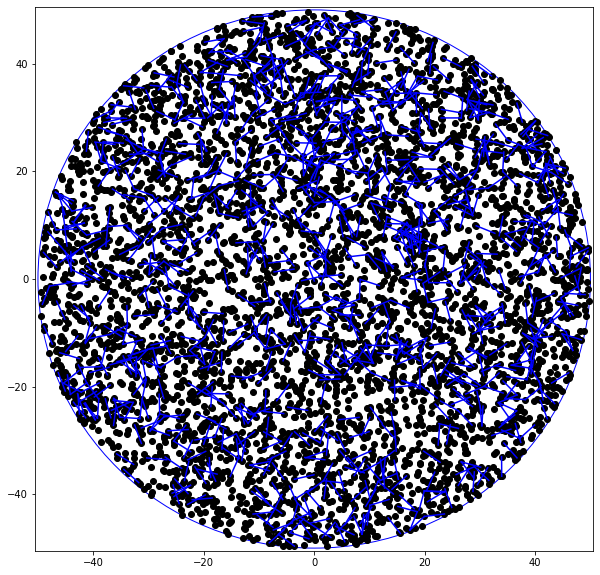

In [31]:
clu.show(show_connections = "yes")

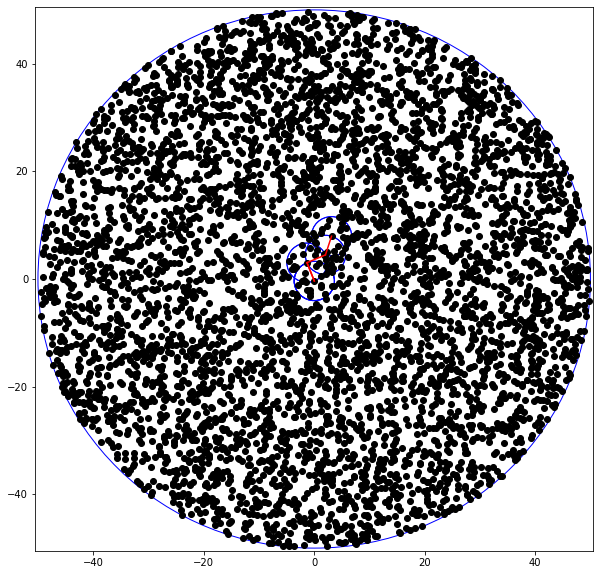

In [32]:
for 
    clu.find_subcluster(ind)
    clu.draw_subcluster(ind)

In [204]:
radius_shell = 6
delta_shell = 0.5
space_radius = 50
step = 50
max_size = 2000

max_lenght = np.zeros(int(max_size/step))

for j, n_points in enumerate(np.arange(0, max_size, step = step)):
    clu = cluster(space_radius=space_radius)
    clu.generate_points(n_points)
    conn = clu.find_connections(radius_shell, delta_shell)
    for i in range(n_points):
        clu.find_subcluster(i)
        if len(clu.subclusters["%d"%i]) > max_lenght[j]:
            max_lenght[j] = len(clu.subclusters["%d"%i])
    clear_output(wait=True)
    print("status: %d %%"%(j/int(max_size/step)*100))

status: 97 %


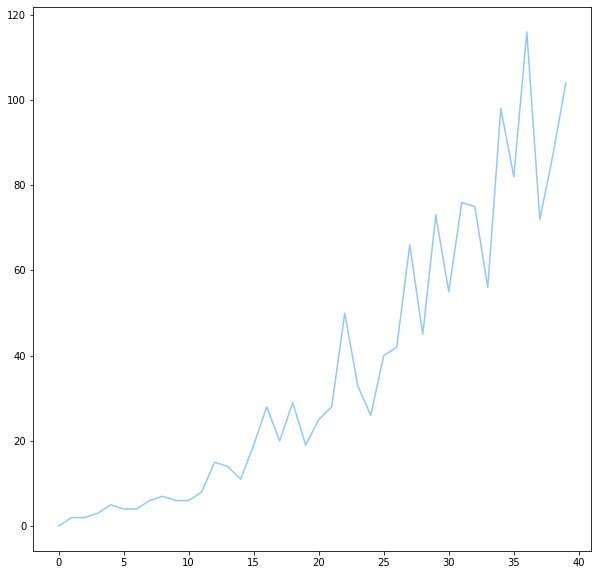

In [205]:
plt.plot(max_lenght)
plt.show()

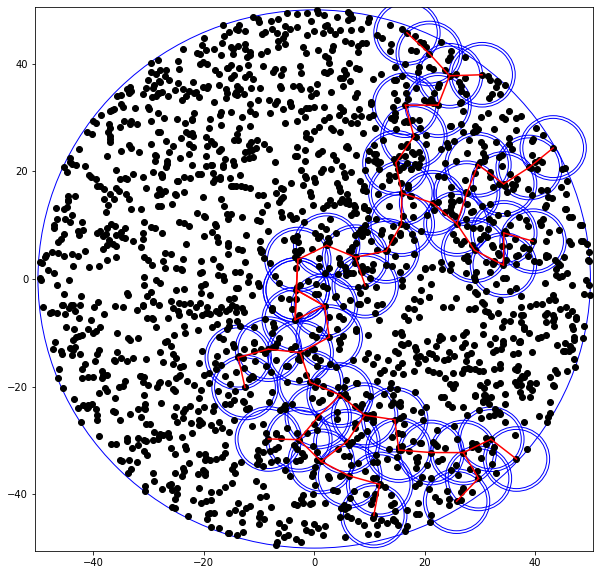

In [206]:
clu.draw_subcluster(11)

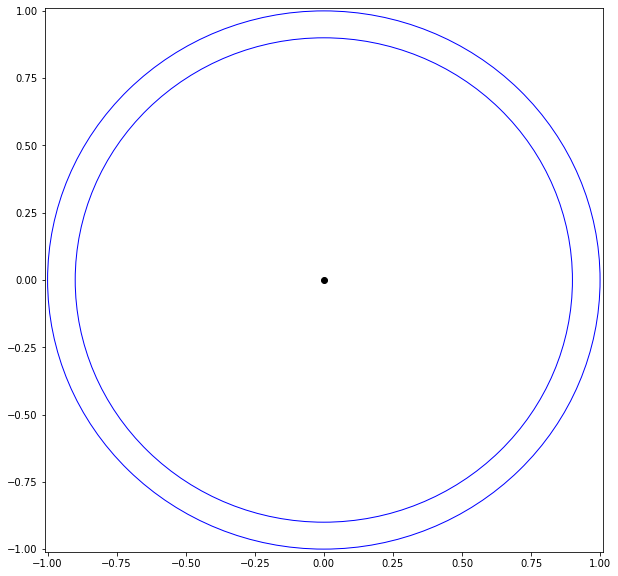

In [31]:
radius = 1
delta = 0.1

ax = plt.gca()
ax.plot([0], [0], "o", color="black")
circ0 = plt.Circle((0,0), radius, color='b', fill=False)
circ1 = plt.Circle((0,0), radius-delta, color='b', fill=False)
ax.add_patch(circ0)
ax.add_patch(circ1)
ax.set_xlim([-radius*1.01,radius*1.01])
ax.set_ylim([-radius*1.01,radius*1.01])
#if self.connections is not None:
#    for j in range(self.size()):
#        for k in self.connections[j]:
#            ax.plot([self.x[j], self.x[k]], [self.y[j], self.y[k]], color="blue")
plt.show()